In [1]:
# ----------------------------------------------------------------------------
# Author        :    Vasileios Perifanis
# Affiliation   :    Euclid team, Democritus University of Thrace, Dept. of Electrical & Computer Engineering
# Created Date  :    03/2022
# version       :    1.0
# ---------------------------------------------------------------------------

In [2]:
#!pip install tenseal

In [3]:
import numpy as np # linear algebra
import pandas as pd # data analysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tenseal as ts

import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("datasets/titanic_train.csv", header=0) # read csv

data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #extract the Salutations

# Assigning the NaN Values the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

data['Embarked'].fillna('S',inplace=True)

data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4

data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

data['Fare_Range']=pd.qcut(data['Fare'],5)
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

data.drop(['Name','Age','Ticket','Fare','Cabin','Initial','Fare_Range','PassengerId'],axis=1,inplace=True)

data.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_band,Family_Size,Alone,Fare_cat
0,0,3,0,1,0,0,1,1,0,0
1,1,1,1,1,0,1,2,1,0,3
2,1,3,1,0,0,0,1,0,1,1
3,1,1,1,1,0,0,2,1,0,3
4,0,3,0,0,0,0,2,0,1,1


In [5]:
def split(data):
    train,test=train_test_split(data,test_size=0.2,random_state=0,stratify=data['Survived'])
    return train, test

def to_numpy(train, test):
    train_X=train[train.columns[1:]].to_numpy()
    train_Y=train[train.columns[:1]].to_numpy().ravel()
    test_X=test[test.columns[1:]].to_numpy()
    test_Y=test[test.columns[:1]].to_numpy().ravel()
    return train_X, train_Y, test_X, test_Y

class ClassifierDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)
    
def generate_dataset(train_x, train_y, batch_size, shuffle=True):
    dataset = ClassifierDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).long())
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

    return loader

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, 128)
        self.out = torch.nn.Linear(128, num_classes)
    
    def activation(self, x):
        return 0.5 + 0.197 * x - 0.004 * x ** 3

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [7]:
class EncryptedMLP:
    def __init__(self, trained_model, approximation='sigmoid'):

        for name, param in trained_model.named_parameters():
            if str(name).endswith("weight"):
                model_params = param.T.tolist()
            elif str(name).endswith("bias"):
                model_params = param.tolist()
            else:
                raise NotImplementedError

        self.layer1_weight = trained_model.layer1.weight.T.data.tolist()
        self.layer1_bias = trained_model.layer1.bias.tolist()

        self.out_weight = trained_model.out.weight.T.data.tolist()
        self.out_bias = trained_model.out.bias.tolist()

        self.approximation = approximation

    def forward(self, enc_x):
        enc_x = enc_x.mm(self.layer1_weight) + self.layer1_bias
        if self.approximation == 'sigmoid':
            enc_x = self._approximate_sigmoid(enc_x)

        enc_x = enc_x.mm(self.out_weight) + self.out_bias
        return enc_x

    def _approximate_sigmoid(self, enc_x):
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [8]:
class EncryptedEvaluation:
    def __init__(self, trained_model):
        self.encrypted_model = EncryptedMLP(trained_model)

    def client_encryption(self,  context, x):
        return ts.ckks_tensor(context, x)

    def encrypted_server_test(self, context, encrypted_x):
        encrypted_out = self.encrypted_model(encrypted_x)
        return encrypted_out

    def client_decryption(self, context, encrypted_out, y, criterion, log=False):
        out = encrypted_out.decrypt().tolist()
        if log:
            print(out)
        out = torch.tensor(out)
        loss = criterion(out, y).item()

        pred = out.argmax(dim=1)

        correct = int((pred == y).sum().item())

        return loss, correct

    def generate_context(self):
        bits_scale = 40
        context = ts.context(ts.SCHEME_TYPE.CKKS,
                             poly_modulus_degree=16384,
                             coeff_mod_bit_sizes=[60,
                                                  bits_scale, bits_scale, bits_scale, bits_scale,
                                                  bits_scale, bits_scale, bits_scale,
                                                  60]
                             )
        context.global_scale = pow(2, bits_scale)
        context.generate_galois_keys()

        return context

In [9]:
def test(model, data, criterion):
    model.eval()
    y_true, y_pred = [], []
    loss, correct = 0., 0
    with torch.no_grad():
        for x, y in data:
            out = model(x)
            loss += criterion(out, y).item()
            pred = out.argmax(dim=1)

            # correct += int((pred == y).sum().item()) # torch accuracy method
            for i in range(len(pred)):
                y_pred.append(pred[i].item())
            for i in range(len(y)):
                y_true.append(y[i].item())
            
    loss = loss / len(data)
    #accuracy = correct / len(data.dataset) # torch accuracy method
    accuracy = accuracy_score(y_pred, y_true)
    precision = precision_score(y_pred, y_true)
    recall = recall_score(y_pred, y_true)
    f1 = f1_score(y_pred, y_true)

    return loss, accuracy, precision, recall, f1

def train(model, train_loader, test_loader, optimizer, criterion, epochs, log_interval=1, plot=True):
    train_loss_history, train_acc_history = [], []  # track loss, accuracy
    test_loss_history, test_acc_history = [], []
    for epoch in range(1, epochs + 1):
        model.train()  # training mode
        for data, target in train_loader:
            optimizer.zero_grad()  # zero out gradients
            y_pred = model(data)  # forward propagation
            loss = criterion(y_pred, target)  # calculate loss
            loss.backward()  # backward pass, compute grads wrt to model parameters
            optimizer.step()  # update weights

        train_loss, train_acc, train_prec, train_rec, train_f = test(model, train_loader, criterion)  # test the model
        test_loss, test_acc, test_pred, test_rec, test_f = test(model, test_loader, criterion)

        train_acc_history.append(train_acc)  # keep metric history
        test_acc_history.append(test_acc)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if epoch % log_interval == 0:  # log
            print(f"Epoch: [{epoch}/{epochs}]: Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f:.4f}\n")
            print(f"\tLoss: {test_loss:.4f}, Eval Accuracy: {test_acc:.4f}, Eval Precision: {train_prec:.4f}, Eval Recall: {train_rec:.4f}, Eval F1: {train_f:.4f}")

    if plot:  # plot history
        plt.plot(train_acc_history, label="Train Acc")
        plt.plot(test_acc_history, label="Test Acc")
        plt.legend()
        plt.show()
        plt.close()

        plt.plot(train_loss_history, label="Train Loss")
        plt.plot(test_loss_history, label="Test Loss")
        plt.legend()
        plt.show()
        plt.close()

    return model

In [10]:
train_df, test_df = split(data)
train_X, train_Y, test_X, test_Y = to_numpy(train_df, test_df)

min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)

train_loader = generate_dataset(train_X, train_Y, batch_size=1024, shuffle=True)
test_loader = generate_dataset(test_X, test_Y, batch_size=1, shuffle=False)

num_classes = len(np.unique(train_Y))
model = MLP(train_X.shape[1], num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()
epochs = 50

Epoch: [1/50]: Loss: 0.8016, Accuracy: 0.6166, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

	Loss: 0.8057, Eval Accuracy: 0.6145, Eval Precision: 0.0000, Eval Recall: 0.0000, Eval F1: 0.0000
Epoch: [2/50]: Loss: 0.6676, Accuracy: 0.6166, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

	Loss: 0.6702, Eval Accuracy: 0.6145, Eval Precision: 0.0000, Eval Recall: 0.0000, Eval F1: 0.0000
Epoch: [3/50]: Loss: 0.6876, Accuracy: 0.4803, Precision: 0.9780, Recall: 0.4231, F1: 0.5907

	Loss: 0.6889, Eval Accuracy: 0.4749, Eval Precision: 0.9780, Eval Recall: 0.4231, Eval F1: 0.5907
Epoch: [4/50]: Loss: 0.7233, Accuracy: 0.3834, Precision: 1.0000, Recall: 0.3834, F1: 0.5543

	Loss: 0.7246, Eval Accuracy: 0.3855, Eval Precision: 1.0000, Eval Recall: 0.3834, Eval F1: 0.5543
Epoch: [5/50]: Loss: 0.6781, Accuracy: 0.6671, Precision: 0.9158, Recall: 0.5388, F1: 0.6784

	Loss: 0.6800, Eval Accuracy: 0.6425, Eval Precision: 0.9158, Eval Recall: 0.5388, Eval F1: 0.6784
Epoch: [6/50]: Loss: 0.6388, Accura

Epoch: [48/50]: Loss: 0.4547, Accuracy: 0.7837, Precision: 0.6850, Recall: 0.7333, F1: 0.7083

	Loss: 0.4768, Eval Accuracy: 0.7933, Eval Precision: 0.6850, Eval Recall: 0.7333, Eval F1: 0.7083
Epoch: [49/50]: Loss: 0.4528, Accuracy: 0.7963, Precision: 0.6777, Recall: 0.7645, F1: 0.7184

	Loss: 0.4759, Eval Accuracy: 0.7933, Eval Precision: 0.6777, Eval Recall: 0.7645, Eval F1: 0.7184
Epoch: [50/50]: Loss: 0.4511, Accuracy: 0.7978, Precision: 0.6777, Recall: 0.7676, F1: 0.7198

	Loss: 0.4750, Eval Accuracy: 0.7933, Eval Precision: 0.6777, Eval Recall: 0.7676, Eval F1: 0.7198


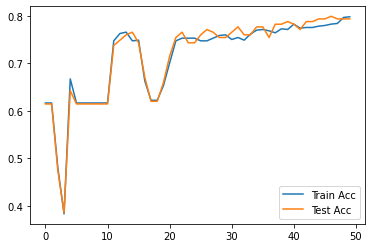

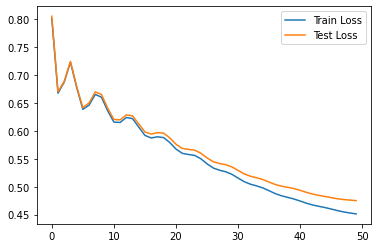

In [11]:
trained_model = train(model, train_loader, test_loader, optimizer, criterion, epochs, log_interval=1, plot=True)

In [12]:
test_loader = generate_dataset(test_X[:5], test_Y[:5], batch_size=1)

In [13]:
print("***Normal Evaluation***")
start = time.time()
test_loss, accuracy, _, _, _ = test(trained_model, test_loader, criterion)
end = time.time()
print(f"Accuracy using plain data: {accuracy:.4f}, loss: {test_loss:.4f}")
print(f"Time elapsed with {len(test_loader)} samples: {end - start} s")

***Normal Evaluation***
Accuracy using plain data: 0.8000, loss: 0.2471
Time elapsed with 5 samples: 0.002893209457397461 s


In [14]:
print("\n***Encrypted Evaluation***")
encrypted_evaluation = EncryptedEvaluation(trained_model)

# STEP 1: client generates keys
context = encrypted_evaluation.generate_context()

start = time.time()
test_loss, test_correct = 0., 0
for i, (x, y) in enumerate(test_loader):
    # STEP 2: Client encrypts local data
    x_enc = encrypted_evaluation.client_encryption(context, x) 
    if i == 0:
        print(x_enc)
    # STEP 3: Server performs evaluation on encrypted data
    encrypted_prediction = encrypted_evaluation.encrypted_server_test(context, x_enc)
    # STEP 4: Client decrypts the result
    loss, correct = encrypted_evaluation.client_decryption(context, encrypted_prediction, y, criterion) 
    test_loss += loss
    test_correct += correct
end = time.time()
test_loss = test_loss / len(test_loader)
accuracy = test_correct / len(test_loader.dataset)

print(f"Accuracy using encrypted data: {accuracy:.4f}, loss: {test_loss:.4f}")
print(f"Time elapsed with {len(test_loader)} samples: {end - start} s")


***Encrypted Evaluation***
Accuracy using encrypted data: 0.8000, loss: 0.2471
Time elapsed with 5 samples: 24.668623447418213 s
